## LSTM Model for Fair Value Estimation

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
date_list_1 = date_list[:-12]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_LSTM_Quintile_Signal = pd.DataFrame(index=list_company)
df_LSTM_Decile_Signal = pd.DataFrame(index=list_company)
df_LSTM_20_Divided_Signal = pd.DataFrame(index=list_company)
df_LSTM_Percentile_Signal = pd.DataFrame(index=list_company)

df_LSTM_Quintile_Signal.index = df_LSTM_Quintile_Signal.index.astype('str')
df_LSTM_Decile_Signal.index = df_LSTM_Decile_Signal.index.astype('str')
df_LSTM_20_Divided_Signal.index = df_LSTM_20_Divided_Signal.index.astype('str')
df_LSTM_Percentile_Signal.index = df_LSTM_Percentile_Signal.index.astype('str')

for i in list_1:
    print(date_list_1[i+12])
    # Baseline LSTM model
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(34, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01),
                        input_shape=(12, 21), return_sequences=False)) # Input layer
    model_LSTM.add(Dropout(0.4))
    model_LSTM.add(Dense(27, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                         bias_regularizer=regularizers.l2(0.01))) # hidden layer 1
    model_LSTM.add(Dropout(0.3))
    model_LSTM.add(Dense(1, activation='linear')) # Output layer
    model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i+13]
    # train the model with 12 months as the rolling window of the data
    train_date = date_list[i:i+12]
    train_date_1 = date_list[i+11]
    # use the model to calculate the 13th month's fair value
    test_date = date_list[i+1:i+13]
    test_date_1 = date_list[i+12]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)
    X_norm.set_index(['cusip'], inplace=True)
    num_cusip = X_norm.index.value_counts().rename('num_cusip')
    X_norm = X_norm.merge(num_cusip, left_index=True, right_index=True)
    X_norm = X_norm[X_norm.num_cusip == 13]
    X_norm.drop('num_cusip', inplace=True, axis=1)
    X_norm.reset_index(inplace=True)
    cusip_list = list(X_norm['index'].unique())

    X_train = X_norm[X_norm.datadate.isin(train_date)]

    X_test = X_norm[X_norm.datadate.isin(test_date)]

    y_train = y[y.datadate.isin(train_date)]

    y_temp = y[y.datadate == test_date_1]
    y_temp_1 = y_temp.set_index(['cusip'])
    y_temp_1 = y_temp_1.merge(num_cusip, left_index=True, right_index=True)
    y_temp_1 = y_temp_1[y_temp_1.num_cusip == 13]
    y_temp_1.drop('num_cusip', inplace=True, axis=1)
    y_temp_1 = y_temp_1.reindex(cusip_list)

    y_fair = pd.DataFrame()

    for k in cusip_list:

        X_train_1 = X_train[X_train['index'] == k]
        X_train_1 = X_train_1.iloc[:, 2:]
        X_train_1 = np.array(X_train_1)
        X_train_1 = tf.expand_dims(X_train_1, axis=0)

        y_train_1 = y_train[y_train.cusip == k]
        y_train_1 = y_train_1.iloc[:, 2]
        y_train_1 = np.array(y_train_1)
        y_train_1 = tf.expand_dims(y_train_1, axis=0)

        model_LSTM.fit(X_train_1, y_train_1, epochs=50, callbacks=[callback])

    for h in cusip_list:

        X_test_1 = X_test[X_test['index'] == h]
        X_test_1 = X_test_1.iloc[:, 2:]
        X_test_1 = np.array(X_test_1)
        X_test_1 = tf.expand_dims(X_test_1, axis=0)

        y_test = y_temp[y_temp.cusip == h]
        y_test = y_test.iloc[:, 2]
        y_test = np.array(y_test)
        y_pred = model_LSTM.predict(X_test_1)
        y_fair = pd.concat([y_fair, pd.DataFrame(y_pred)], axis=0)

    y_fair = pd.DataFrame(y_fair)
    y_fair.rename(columns={0 :'Fair_Value'}, inplace=True)
    y_fair = y_fair.reset_index().drop('index', axis=1)
    y_final = pd.concat([y_temp_1.reset_index(), y_fair], axis=1)
    y_final.set_index('index', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_LSTM_Quintile_Signal = df_LSTM_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date_1), how='left')
    df_LSTM_Decile_Signal = df_LSTM_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date_1), how='left')
    df_LSTM_20_Divided_Signal = df_LSTM_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date_1), how='left')
    df_LSTM_Percentile_Signal = df_LSTM_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date_1), how='left')
    print('{} is done'.format(date_list_1[i+12]))

### (1) Performance Analysis

In [169]:
cusip_1 = pd.Series(df_returns.T.index).rename('cusip')
df_LSTM_Quintile_Signal = pd.read_csv('df_LSTM_quintile_9904_2205_300.csv')
df_LSTM_Decile_Signal = pd.read_csv('df_LSTM_decile_9904_2205_300.csv')
df_LSTM_20_Divided_Signal = pd.read_csv('df_LSTM_20_9904_2205_300.csv')
df_LSTM_Percentile_Signal = pd.read_csv('df_LSTM_percentile_9904_2205_300.csv')

df_LSTM_Quintile_Signal.drop('Unnamed: 0', axis=1, inplace=True)
df_LSTM_Decile_Signal.drop('Unnamed: 0', axis=1, inplace=True)
df_LSTM_20_Divided_Signal.drop('Unnamed: 0', axis=1, inplace=True)
df_LSTM_Percentile_Signal.drop('Unnamed: 0', axis=1, inplace=True)

df_LSTM_Quintile_Signal.columns = date_list[12:]
df_LSTM_Decile_Signal.columns = date_list[12:]
df_LSTM_20_Divided_Signal.columns = date_list[12:]
df_LSTM_Percentile_Signal.columns = date_list[12:]

df_LSTM_Quintile_Signal = pd.concat([cusip_1, df_LSTM_Quintile_Signal], axis=1)
df_LSTM_Decile_Signal = pd.concat([cusip_1, df_LSTM_Decile_Signal], axis=1)
df_LSTM_20_Divided_Signal = pd.concat([cusip_1, df_LSTM_20_Divided_Signal], axis=1)
df_LSTM_Percentile_Signal = pd.concat([cusip_1, df_LSTM_Percentile_Signal], axis=1)

df_LSTM_Quintile_Signal.set_index('cusip', inplace=True)
df_LSTM_Decile_Signal.set_index('cusip', inplace=True)
df_LSTM_20_Divided_Signal.set_index('cusip', inplace=True)
df_LSTM_Percentile_Signal.set_index('cusip', inplace=True)

df_LSTM_Quintile_Signal.index = df_LSTM_Quintile_Signal.index.astype('str')
df_LSTM_Decile_Signal.index = df_LSTM_Decile_Signal.index.astype('str')
df_LSTM_20_Divided_Signal.index = df_LSTM_20_Divided_Signal.index.astype('str')
df_LSTM_Percentile_Signal.index = df_LSTM_Percentile_Signal.index.astype('str')

In [170]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_LSTM_Quintile_Signal = pd.concat([df_199804_199809, df_LSTM_Quintile_Signal, df_202206], axis=1)
df_LSTM_Quintile_Signal = df_LSTM_Quintile_Signal.fillna(0).T
df_LSTM_Quintile_Signal = df_LSTM_Quintile_Signal.shift(1).dropna()

df_LSTM_Decile_Signal = pd.concat([df_199804_199809, df_LSTM_Decile_Signal, df_202206], axis=1)
df_LSTM_Decile_Signal = df_LSTM_Decile_Signal.fillna(0).T
df_LSTM_Decile_Signal = df_LSTM_Decile_Signal.shift(1).dropna()

df_LSTM_20_Divided_Signal = pd.concat([df_199804_199809, df_LSTM_20_Divided_Signal, df_202206], axis=1)
df_LSTM_20_Divided_Signal = df_LSTM_20_Divided_Signal.fillna(0).T
df_LSTM_20_Divided_Signal = df_LSTM_20_Divided_Signal.shift(1).dropna()

df_LSTM_Percentile_Signal = pd.concat([df_199804_199809, df_LSTM_Percentile_Signal, df_202206], axis=1)
df_LSTM_Percentile_Signal = df_LSTM_Percentile_Signal.fillna(0).T
df_LSTM_Percentile_Signal = df_LSTM_Percentile_Signal.shift(1).dropna()

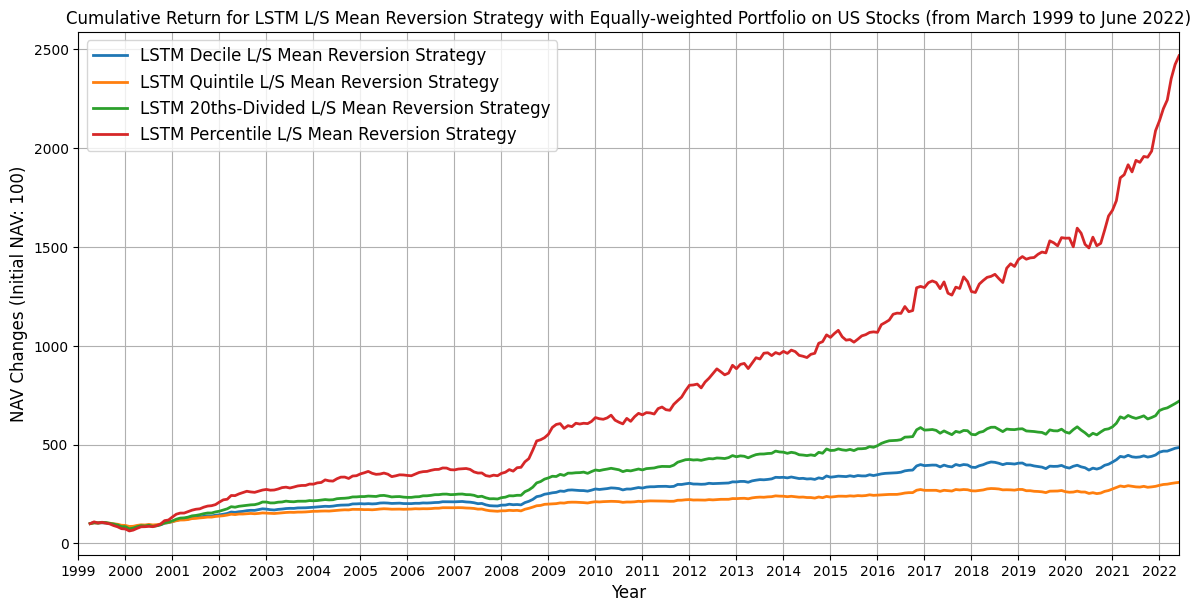

In [171]:
cum_LSTM_Q_strategy_return = get_price_df(df_LSTM_Quintile_Signal, df_returns, nav=100, model_type='LSTM')
cum_LSTM_D_strategy_return = get_price_df(df_LSTM_Decile_Signal, df_returns, nav=100, model_type='LSTM')
cum_LSTM_T_strategy_return = get_price_df(df_LSTM_20_Divided_Signal, df_returns, nav=100, model_type='LSTM')
cum_LSTM_P_strategy_return = get_price_df(df_LSTM_Percentile_Signal, df_returns, nav=100, model_type='LSTM')

cum_LSTM_strategy_return = pd.concat([cum_LSTM_D_strategy_return.rename('LSTM Decile L/S Mean Reversion Strategy'),
                                     cum_LSTM_Q_strategy_return.rename('LSTM Quintile L/S Mean Reversion Strategy'),
                                     cum_LSTM_T_strategy_return.rename('LSTM 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_LSTM_P_strategy_return.rename('LSTM Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_LSTM_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for LSTM L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from March 1999 to June 2022)',
          fontsize=12)
plt.show()

In [235]:
# Performance Stats
stats_LSTM_Q = get_performance_stats(cum_LSTM_Q_strategy_return, rfr=risk_free_rate_df, label='LSTM Quintile (Initial NAV: 100)')
stats_LSTM_D = get_performance_stats(cum_LSTM_D_strategy_return, rfr=risk_free_rate_df, label='LSTM Decile (Initial NAV: 100)')
stats_LSTM_T = get_performance_stats(cum_LSTM_T_strategy_return, rfr=risk_free_rate_df, label='LSTM 20ths (Initial NAV: 100)')
stats_LSTM_P = get_performance_stats(cum_LSTM_P_strategy_return, rfr=risk_free_rate_df, label='LSTM Percentile (Initial NAV: 100)')
LSTM_stats = pd.concat([stats_LSTM_Q, stats_LSTM_D, stats_LSTM_T, stats_LSTM_P], axis=0)
display(LSTM_stats)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
LSTM Quintile (Initial NAV: 100),2.087045,0.049677,0.018682,0.052387,0.591642,0.129980,1.877523,308.704538,2022-06-30,0.093175,2018-06-30,2020-09-30,2021-02-28,974
LSTM Decile (Initial NAV: 100),3.849807,0.070270,0.018682,0.068806,0.749763,-0.162416,4.360367,484.980742,2022-06-30,0.099320,2018-06-30,2020-07-31,2021-02-28,974
LSTM 20ths (Initial NAV: 100),6.195353,0.088585,0.018682,0.084896,0.823393,-0.247919,5.839995,719.535328,2022-06-30,0.080493,2020-04-30,2020-07-31,2021-02-28,304
LSTM Percentile (Initial NAV: 100),23.673153,0.147838,0.018682,0.116095,1.112498,0.470442,4.540388,2467.315313,2022-06-30,0.062825,2020-04-30,2020-07-31,2020-12-31,245


In [236]:
stats2_LSTM_Q = get_performance_stats_2(df_LSTM_Quintile_Signal, df_returns, df_market_cap, label='LSTM Quintile', model_type='LSTM')
stats2_LSTM_D = get_performance_stats_2(df_LSTM_Decile_Signal, df_returns, df_market_cap, label='LSTM Decile', model_type='LSTM')
stats2_LSTM_T = get_performance_stats_2(df_LSTM_20_Divided_Signal, df_returns, df_market_cap, label='LSTM 20ths', model_type='LSTM')
stats2_LSTM_P = get_performance_stats_2(df_LSTM_Percentile_Signal, df_returns, df_market_cap, label='LSTM Percentile', model_type='LSTM')
LSTM_stats2 = pd.concat([stats2_LSTM_Q, stats2_LSTM_D, stats2_LSTM_T, stats2_LSTM_P], axis=0)
display(LSTM_stats2)

,Total Return,Avg Monthly Return,Avg Mkt Cap,Fraction>0,+ Return Stocks (Avg),- Return Stocks (Avg),Odds Ratio,Odds Ratio 98-10,Odds Ratio 11-22,Transactions/Month
LSTM Quintile (Long & Short),2.087045,0.004048,2.657858e+10,0.568966,0.083051,-0.076613,0.501329,0.510163,0.494641,349.521127
(Long Position),74.273787,0.015608,1.861709e+09,0.637931,0.086847,-0.070305,0.551843,0.560298,0.545470,147.563380
(Short Position),-0.933762,-0.009682,5.077376e+10,0.372414,0.065125,-0.071403,0.452040,0.461489,0.444854,208.802817
LSTM Decile (Long & Short),3.849807,0.005675,4.109825e+10,0.600000,0.085280,-0.076995,0.506566,0.516177,0.499314,220.443662
(Long Position),196.882870,0.019133,1.521100e+09,0.651724,0.089156,-0.067513,0.558029,0.569655,0.549331,93.890845
(Short Position),-0.939169,-0.009984,7.936403e+10,0.362069,0.067147,-0.074200,0.457051,0.465204,0.450849,127.750000
LSTM 20ths (Long & Short),6.195353,0.007098,6.697533e+10,0.617241,0.085800,-0.076185,0.512604,0.525403,0.502963,127.813380
(Long Position),518.566489,0.022665,1.435077e+09,0.668966,0.089235,-0.063917,0.567492,0.588053,0.552181,59.619718
(Short Position),-0.950084,-0.010686,1.291953e+11,0.372414,0.067788,-0.076009,0.460816,0.467038,0.456079,68.514085
LSTM Percentile (Long & Short),23.673153,0.011556,2.113307e+11,0.631034,0.087087,-0.074591,0.534528,0.541563,0.529164,33.461268


In [57]:
cum_LSTM_Q_strategy_return_L = get_price_df(df_LSTM_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_LSTM_Q_strategy_return_S = get_price_df(df_LSTM_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_LSTM_D_strategy_return_L = get_price_df(df_LSTM_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_LSTM_D_strategy_return_S = get_price_df(df_LSTM_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_LSTM_Q_L = get_performance_stats(cum_LSTM_Q_strategy_return_L, rfr=risk_free_rate_df, label='LSTM Quintile L (Initial NAV: 100)')
stats_LSTM_Q_S = get_performance_stats(cum_LSTM_Q_strategy_return_S, rfr=risk_free_rate_df, label='LSTM Quintile S (Initial NAV: 100)')
stats_LSTM_D_L = get_performance_stats(cum_LSTM_D_strategy_return_L, rfr=risk_free_rate_df, label='LSTM Decile L (Initial NAV: 100)')
stats_LSTM_D_S = get_performance_stats(cum_LSTM_D_strategy_return_S, rfr=risk_free_rate_df, label='LSTM Decile S (Initial NAV: 100)')
LSTM_stats3 = pd.concat([stats_LSTM_Q_L, stats_LSTM_Q_S, stats_LSTM_D_L, stats_LSTM_D_S], axis=0)
display(LSTM_stats3)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
LSTM Quintile L (Initial NAV: 100),74.273787,0.204248,0.018682,0.172630,1.074932,0.073729,0.604037,8552.245930,2021-12-31,0.235709,2019-12-31,2020-03-31,2020-07-31,213
LSTM Quintile S (Initial NAV: 100),6.535888,0.090752,0.018682,0.170555,0.422561,-0.422955,1.061229,1017.564037,2021-10-31,0.259419,2021-10-31,2022-06-30,Yet to recover,Yet to recover
LSTM Decile L (Initial NAV: 100),196.882870,0.255366,0.018682,0.170143,1.391085,0.320546,0.646821,22369.690618,2021-10-31,0.115397,2021-10-31,2022-06-30,Yet to recover,Yet to recover
LSTM Decile S (Initial NAV: 100),6.148361,0.088279,0.018682,0.186981,0.372209,-0.232251,1.548567,1007.815961,2021-10-31,0.290708,2021-10-31,2022-06-30,Yet to recover,Yet to recover


### (2) Hyperparameters Tuning

In [176]:
validation_date = date_list[:12]

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_norm.set_index(['cusip'], inplace=True)
num_cusip = X_norm.index.value_counts().rename('num_cusip')
X_norm = X_norm.merge(num_cusip, left_index=True, right_index=True)
X_norm = X_norm[X_norm.num_cusip == 12]
X_norm.drop('num_cusip', inplace=True, axis=1)
X_norm.reset_index(inplace=True)
cusip_list = list(X_norm['index'].unique())

y_temp = y[y.datadate.isin(validation_date)]
y_temp.set_index(['cusip'], inplace=True)
num_cusip = y_temp.index.value_counts().rename('num_cusip')
y_temp = y_temp.merge(num_cusip, left_index=True, right_index=True)
y_temp = y_temp[y_temp.num_cusip == 12]
y_temp.drop('num_cusip', inplace=True, axis=1)
y_temp.reset_index(inplace=True)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
def creating_LSTM(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer', min_value=1, max_value = 40, step = 1)
    unit2 = hp.Int('lay1', min_value=1, max_value = 40, step = 1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values = [1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1  = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])


    model.add(LSTM(unit1, kernel_regularizer=regularizers.l2(unit9), bias_regularizer=regularizers.l2(unit9),
                   input_shape=(12, 21), return_sequences=False))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
for k in cusip_list:
    X_train_1 = X_norm[X_norm['index'] == k]
    X_validation = X_train_1.iloc[:, 2:]
    X_validation = np.array(X_validation)
    X_validation = tf.expand_dims(X_validation, axis=0)

    y_train_1 = y_temp[y_temp['index'] == k]
    y_validation = y_train_1.iloc[:, 2]
    y_validation = np.array(y_validation)
    y_validation = tf.expand_dims(y_validation, axis=0)

    tuner_lstm = kt.Hyperband(creating_LSTM, objective='val_loss', max_epochs=10, project_name='lstm_tuning', overwrite=True)
    tuner_lstm.search(X_validation, y_validation, epochs=1, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=1)

In [ ]:
"""
Hyperparameters:
LSTM layer: 34
lay1: 27
dropout1: 0.4
dropout2: 0.3
regularization: 0.01
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 50
"""

### (3) Feature Importance

In [ ]:
date_list_2 = date_list[:-12]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

# Baseline LSTM model
model_LSTM = Sequential()
model_LSTM.add(LSTM(34, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01),
                    input_shape=(12, 21), return_sequences=False)) # Input layer
model_LSTM.add(Dropout(0.4))
model_LSTM.add(Dense(27, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                     bias_regularizer=regularizers.l2(0.01))) # hidden layer 1
model_LSTM.add(Dropout(0.3))
model_LSTM.add(Dense(1, activation='linear')) # Output layer
model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

temp_date = date_list_2[0:13]
# train the model with 12 months as the rolling window of the data
train_date = date_list_2[0:12]
train_date_1 = date_list_2[11]
# use the model to calculate the 13th month's fair value
test_date = date_list_2[1:13]
test_date_1 = date_list_2[12]

X_temp = X[X.datadate.isin(temp_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_norm.set_index(['cusip'], inplace=True)
num_cusip = X_norm.index.value_counts().rename('num_cusip')
X_norm = X_norm.merge(num_cusip, left_index=True, right_index=True)
X_norm = X_norm[X_norm.num_cusip == 13]
X_norm.drop('num_cusip', inplace=True, axis=1)
X_norm.reset_index(inplace=True)
cusip_list = list(X_norm['index'].unique())

X_train = X_norm[X_norm.datadate.isin(train_date)]

X_test = X_norm[X_norm.datadate.isin(test_date)]

y_train = y[y.datadate.isin(train_date)]

y_temp = y[y.datadate == test_date_1]

y_fair = pd.DataFrame()

for k in cusip_list:
  X_train_1 = X_train[X_train['index'] == k]
  X_train_1 = X_train_1.iloc[:, 2:]
  X_train_1 = np.array(X_train_1)
  X_train_1 = tf.expand_dims(X_train_1, axis=0)

  y_train_1 = y_train[y_train.cusip == k]
  y_train_1 = y_train_1.iloc[:, 2]
  y_train_1 = np.array(y_train_1)
  y_train_1 = tf.expand_dims(y_train_1, axis=0)

  model_LSTM.fit(X_train_1, y_train_1, epochs=5, callbacks=[callback])

In [ ]:
char_list = list(df_target_features.columns[1:])
feature_importance_all = pd.DataFrame(index=char_list)

for i in cusip_list:
  print(i)
  X_test_1 = X_test[X_test['index'] == i]
  X_test_1 = X_test_1.iloc[:, 2:]
  y_temp_1 = y_temp[y_temp.cusip == i]
  y_temp_1 = y_temp_1.iloc[:, 2]
  y_test_1 = tf.expand_dims(y_temp_1, axis=0)
  difference_list = []

  for char in char_list:
    temp_test = X_test_1.copy()
    temp_test[char] = 0
    temp_test = tf.expand_dims(temp_test, axis=0)
    temp_predict = pd.DataFrame(model_LSTM.predict(temp_test, steps=1))
    temp_mse = (temp_predict.iloc[0,0] - y_temp_1.reset_index(drop=True)[0]) ** 2
    difference_list.append(temp_mse)
  variable_importance = pd.DataFrame([char_list, difference_list]).T
  variable_importance.columns = ['characteristics','importance']
  variable_importance['importance'] = variable_importance['importance']/(variable_importance['importance'].sum())
  variable_importance = variable_importance.sort_values('importance',ascending=False)
  variable_importance.reset_index(drop=True,inplace=True)
  variable_importance = variable_importance.set_index('characteristics')
  variable_importance.rename(columns={'importance': i}, inplace=True)
  feature_importance_all = feature_importance_all.merge(variable_importance, how='left', left_index=True, right_index=True)

In [154]:
char_list = list(df_target_features.columns[1:])
feature_importance_all = pd.read_csv('feature_importance_LSTM.csv', index_col=0)
feature_importance_all['mean'] = feature_importance_all.mean(axis=1)

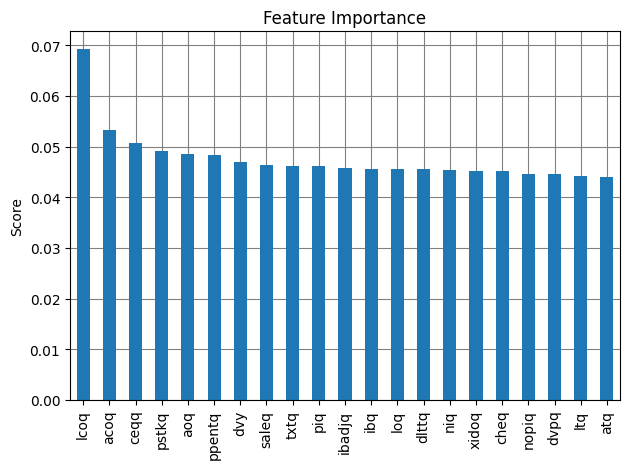

In [155]:
fig, ax1 = plt.subplots()
feature_importance_all['mean'].sort_values(ascending=False).plot.bar(ax=ax1)
ax1.set_axisbelow(True)
ax1.grid(color='gray')
ax1.set_title('Feature Importance')
ax1.set_ylabel('Score')
fig.tight_layout()
plt.show()